In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
ntrain = 250
sub = 1
Sx = Sy = int(((1024 - 1) / sub) + 1)
maps = np.load('/mountvol/2D-1024-Dataset-0/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[0,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

Comparing Euclidean Norm

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)



Testing Euclidean Norm
Average Path Cost: 597.7658480728428 
Average Planning Time: 3.9089562273025513 
Average Inference Time: 0.030450849533081054 
Average Number of Node Expansions: 61119.82 
Average Success Rate: 1.0


Planning Operator

In [5]:
# Model
modes = 8
width = 28
nlayers = 1

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/2D-1024-Dataset-0/planningoperator_street_maps_1024x1024_8m_28w_1l_b5/n500_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model1024.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_9613/872346261.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/2D-1024-Dataset-0/planningoperator_street_maps_

PlanningOperator2D(
  (fc0): Linear(in_features=2, out_features=28, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(28, 28, kernel_size=(1, 1), stride=(1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=28, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

100%|██████████| 9/9 [02:18<00:00, 15.35s/it]


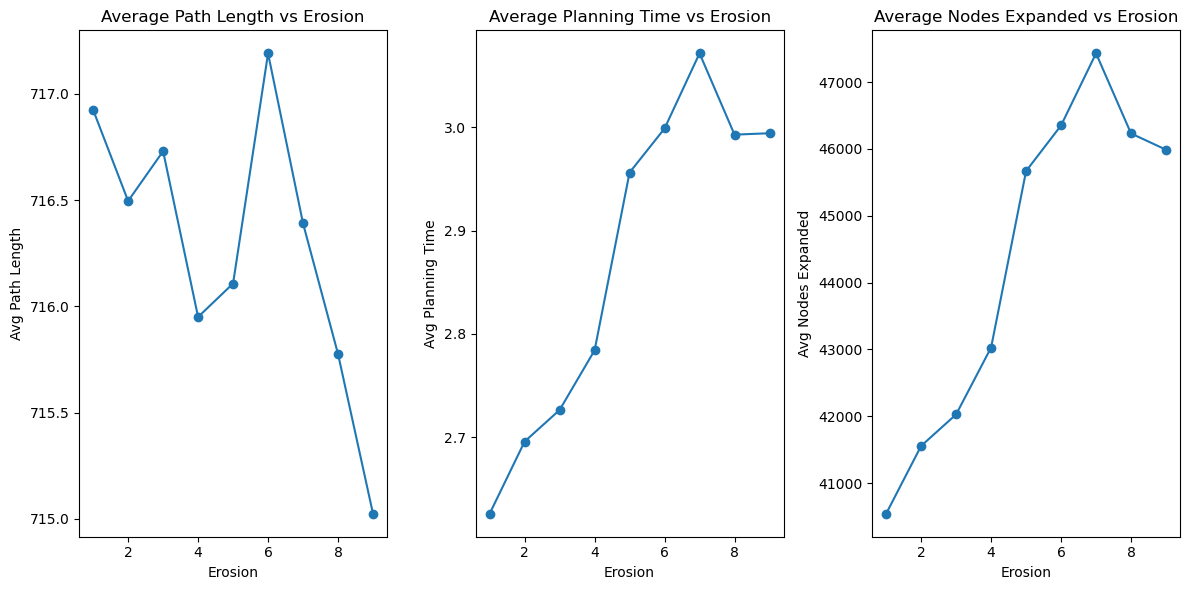

In [6]:

from tqdm import tqdm 

erosionmaps = maps[::10, :, :]
erosionstartpos = startpositions[::10,:]
erosiongoalpos = goalpositions[::10,:]

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in tqdm(range(1, 10)):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        erosionstartpos, erosiongoalpos, erosionmaps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

plt.figure(figsize=(12, 6))

# Plot for avgpathcost (Average Path Length)
plt.subplot(1, 3, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Length vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Length')

# Plot for avgplantime (Average Planning Time)
plt.subplot(1, 3, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avgnodesexp (Average Nodes Expanded)
plt.subplot(1, 3, 3)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

plt.tight_layout()
plt.show()

In [7]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 15, model=model)

Testing PNO


Average Path Cost: 600.9912896316157 
Average Planning Time: 2.7360012197494505 
Average Inference Time: 0.1823161220550537 
Average Number of Node Expansions: 41803.42 
Average Success Rate: 1.0


In [9]:
import pickle
data = {
    "startpositions": startpositions,
    "goalpositions": goalpositions,
    "maps": maps,
    "euclidean_results": euclidean_results,
    "no_results": no_results,
    "erosion_values": erosion_values,
    "avgpathcost_values": avgpathcost_values,
    "avgplantime_values": avgplantime_values,
    "avginfertime_values": avginfertime_values,
    "avgnodesexp_values": avgnodesexp_values,
    "avgsuccessrate_values": avgsuccessrate_values
}

# Save to file using pickle, ignoring the model
with open("1024map.pkl", "wb") as file:
    pickle.dump(data, file)

print("Data saved successfully")

Data saved successfully
